<a href="https://colab.research.google.com/github/HarithaPalat/devtown_reactjs_workshop/blob/main/Copy_of_Currency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import shutil
with zipfile.ZipFile("indian_currency_new.zip","r") as f:
  f.extractall('.')


DIR='./indian_currency_new'
import tensorflow as tf
device_name=tf.test.gpu_device_name()
if device_name!='/device:GPU:0':
	raise SystemError('GPU device not found')

print('Found GPU at:{}'.format(device_name))


Found GPU at:/device:GPU:0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np

DIR = '/content/indian_currency_new'  # Update with your dataset directory
TRAINING_DATA_PATH = DIR + '/training'
VALID_DATA_DIR = DIR + '/validation'
IMG_SIZE = (250, 500)
NUM_CLASSES = 8
BATCH_SIZE = 6
NUM_EPOCH = 15
FREEZE_LAYERS = 16
LEARNING_RATE = 0.0002

# Model
model = Xception(include_top=False, weights='imagenet', input_tensor=None, input_shape=(250, 500, 3))
top_layer = model.output
x = GlobalAveragePooling2D()(top_layer)
op = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
model_final = Model(inputs=model.input, outputs=op)

# Freeze layers
for layer in model_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False

# Unfreeze layers
for layer in model_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

model_final.compile(optimizer=Adam(lr=LEARNING_RATE),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

print(model_final.summary())

# Data Augmentation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=20)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=20)

# Assuming your labels are in train_batches.classes and valid_batches.classes
train_labels_one_hot = to_categorical(train_batches.classes, NUM_CLASSES)
valid_labels_one_hot = to_categorical(valid_batches.classes, NUM_CLASSES)

train_batches = train_datagen.flow_from_directory(TRAINING_DATA_PATH,
                                                  target_size=IMG_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')

valid_batches = test_datagen.flow_from_directory(VALID_DATA_DIR,
                                                 target_size=IMG_SIZE,
                                                 shuffle=True,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')

checkpoint = ModelCheckpoint('Xception_model.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

model_final.fit(train_batches,
                steps_per_epoch=np.ceil(len(train_batches) / BATCH_SIZE),
                validation_data=valid_batches,
                validation_steps=np.ceil(len(valid_batches) / BATCH_SIZE),
                epochs=NUM_EPOCH,
                callbacks=[checkpoint, early])

#test_categories=os.listdir(DST)
class_dictionary=train_batches.class_indices
class_dictionary
vals = list(class_dictionary.values())
keys = list(class_dictionary.keys())


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 250, 500, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 124, 249, 32)         864       ['input_10[0][0]']            
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 124, 249, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 124, 249, 32)         0         ['block1_conv1_bn[0][0]'

1/1 [==============================] - 2s 2s/step
Model predicts class 2000 with confidence 99.73944425582886


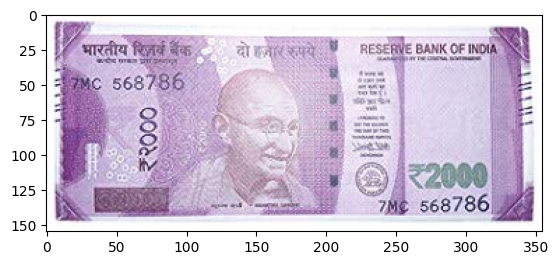

In [ ]:
from tensorflow.keras.preprocessing import image

path = '/content/indian_currency_new/training/2000/12.jpg'
img = plt.imread(path)
plt.imshow(img)

# Prediction
img = image.load_img(path, target_size=IMG_SIZE)
array = image.img_to_array(img)
test_image = np.expand_dims(array, axis=0)
test_image = preprocess_input(test_image)
prediction = model_final.predict(test_image)
predicted_class_index = np.argmax(prediction, axis=1)[0]
confidence = prediction[0, predicted_class_index] * 100
predicted_class = keys[vals.index(predicted_class_index)]

print(f'Model predicts class {predicted_class} with confidence {confidence}')
